In [ ]:
!pip install dwave-ocean-sdk

In [2]:
!dwave config create

Found existing configuration file: /root/.config/dwave/dwave.conf
Configuration file path [/root/.config/dwave/dwave.conf]: 
Profile (create new or choose from: prod): y
API endpoint URL [skip]: 
Authentication token [skip]: 
Aborted!
^C


In [53]:
import itertools
import os
from sklearn.datasets import load_iris
import matplotlib
matplotlib.use("agg")    # must select backend before importing pyplot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd

# D-Wave Ocean tools
import dimod
from dwave.embedding.chimera import find_clique_embedding
from dwave.system import DWaveSampler, FixedEmbeddingComposite


In [54]:
X = load_iris()

In [55]:
data = pd.DataFrame(data= X.data,
                     columns= X['feature_names'])

In [56]:
data['target'] = X.target

In [57]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [23]:
# Define MI calculations
def prob(dataset):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [len(np.unique(dataset[:, ci])) for ci in range(num_columns)]

    prob, _ = np.histogramdd(dataset, bins)
    return prob / np.sum(prob)


def shannon_entropy(p):
    """Shannon entropy H(X) is the negative sum of P(X)log(P(X)) for probability
    distribution P(X).
    """
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)


def conditional_shannon_entropy(p, *conditional_indices):
    """Conditional Shannon entropy H(X|Y) = H(X,Y) - H(Y)."""

    axis = tuple(i for i in np.arange(len(p.shape))
                 if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))


def mutual_information(prob, j):
    """Mutual information between variables X and variable Y.
    Calculated as I(X; Y) = H(X) - H(X|Y)."""

    return (shannon_entropy(np.sum(prob, axis=j))
            - conditional_shannon_entropy(prob, j))


def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z.
    Calculated as I(X;Y|Z) = H(X|Z) - H(X|Y,Z)"""

    return (conditional_shannon_entropy(np.sum(p, axis=j), *conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

In [58]:
def run_demo(data=None, flag = True):
    # Read the feature-engineered data into a pandas dataframe
    # Data obtained from http://biostat.mc.vanderbilt.edu/DataSets

    if flag:
      dataset = data
    else:
      data_path = '/content/sample_data/california_housing_train.csv'
      dataset = pd.read_csv(data_path)

    # Rank the MI between survival and every other variable
    scores = {}
    features = list(set(dataset.columns).difference(('target',)))
    for feature in features:
        scores[feature] = mutual_information(prob(dataset[['target', feature]].values), 0)

    labels, values = zip(*sorted(scores.items(), key=lambda pair: pair[1], reverse=True))

    # Plot the MI between survival and every other variable
    plt.figure()
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Mutual Information")
    ax1.set_ylabel('MI Between Survival and Feature')
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.bar(np.arange(len(labels)), values)

    # The Titanic dataset provides a familiar, intuitive example available in the public
    # domain. In itself, however, it is not a good fit for solving by sampling. Run naively on
    # this dataset, it finds numerous good solutions but is unlikely to find the exact optimal solution.
    # There are many techniques for reformulating problems for the D-Wave system that can
    # improve performance on various metrics, some of which can help narrow down good solutions
    # to closer approach an optimal solution.
    # This demo solves the problem for just the highest-scoring features.

    # Select 8 features with the top MI ranking found above.
    keep = 8

    sorted_scores = sorted(scores.items(), key=lambda pair: pair[1], reverse=True)
    dataset = dataset[[column[0] for column in sorted_scores[0:keep]] + ["target"]]
    features = list(set(dataset.columns).difference(('target',)))

    # Build a QUBO that maximizes MI between survival and a subset of features
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # Add biases as (negative) MI with survival for each feature
    for feature in features:
        mi = mutual_information(prob(dataset[['target', feature]].values), 1)
        bqm.add_variable(feature, -mi)

    # Add interactions as (negative) MI with survival for each set of 2 features
    for f0, f1 in itertools.combinations(features, 2):
        cmi_01 = conditional_mutual_information(prob(dataset[['target', f0, f1]].values), 1, 2)
        cmi_10 = conditional_mutual_information(prob(dataset[['target', f1, f0]].values), 1, 2)
        bqm.add_interaction(f0, f1, -cmi_01)
        bqm.add_interaction(f1, f0, -cmi_10)

    bqm.normalize()  # Normalize biases & interactions to the range -1, 1

    # Set up a QPU sampler with a fully-connected graph of all the variables
    qpu_sampler = DWaveSampler(solver={'qpu': True})

    embedding = find_clique_embedding(bqm.variables,
                                      16, 16, 4,  # size of the chimera lattice
                                      target_edges=qpu_sampler.edgelist)

    sampler = FixedEmbeddingComposite(qpu_sampler, embedding)

    # For each number of features, k, penalize selection of fewer or more features
    selected_features = np.zeros((len(features), len(features)))
    for k in range(1, len(features) + 1):
        kbqm = bqm.copy()
        kbqm.update(dimod.generators.combinations(features, k,
                                                  strength=6))  # Determines the penalty

        sample = sampler.sample(kbqm, num_reads=10000).first.sample

        for fi, f in enumerate(features):
            selected_features[k-1, fi] = sample[f]

    # Plot the best feature set per number of selected features
    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title("Best Feature Selection")
    ax2.set_ylabel('Number of Selected Features')
    ax2.set_xticks(np.arange(len(features)))
    ax2.set_xticklabels(features, rotation=90)
    ax2.set_yticks(np.arange(len(features)))
    ax2.set_yticklabels(np.arange(1, len(features)+1))
    # Set a grid on minor ticks
    ax2.set_xticks(np.arange(-0.5, len(features)), minor=True)
    ax2.set_yticks(np.arange(-0.5, len(features)), minor=True)
    ax2.grid(which='minor', color='black')
    ax2.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))

    plt.show()
    plots_path = os.path.join('/content/', "plots_iris.png")
    plt.savefig(plots_path, bbox_inches="tight")
    print("Your plots are saved to {}".format(plots_path))

Your plots are saved to /content/plots_iris.png


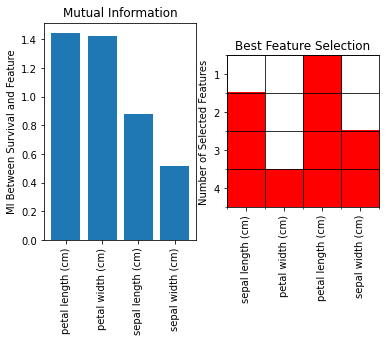

In [59]:
if __name__ == "__main__":
    run_demo(data, flag = True)